In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install -q implicit
import implicit

In [7]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
import random
import re
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity  # ROUGE-L - for text similarity: https://www.tensorflow.org/text/tutorials/text_similarity
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import itertools
from tensorflow.keras.layers import TextVectorization
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
np.random.seed(1)
users_root = r'/content/drive/My Drive/data/books/Users.csv'
books_root = r'/content/drive/My Drive/data/books/Books.csv'
ratings_root = r'/content/drive/My Drive/data/books/Ratings.csv'

In [9]:
users = pd.read_csv(users_root, encoding='utf-8')
books = pd.read_csv(books_root, encoding='utf-8')
ratings = pd.read_csv(ratings_root, encoding='utf-8')

In [ ]:
users.head(2)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0


In [ ]:
# fillna from normal distribution, as Age have to be normally distributed
"""
index = users[users.Age.isna()].index
value = np.random.normal(loc=users.Age.mean(), scale=users.Age.std(), size=users.Age.isna().sum())
users.Age.fillna(pd.Series(np.abs(value), index=index), inplace=True)
index = users[users.Age < 2].index
value = np.random.normal(loc=np.abs(users.Age.mean()), scale=users.Age.std(), size=len(users[users.Age<2]))
"""

In [ ]:
def snow_stem(text):
    snow_stemmer = SnowballStemmer(language='english')
    new_text = ''
    for word in text.split():
        new_text += snow_stemmer.stem(word) + ' '
    return new_text

In [ ]:
q1 = np.quantile(users.Age.dropna(), q=0.25)
q3 = np.quantile(users.Age.dropna(), q=0.75)
iqr1, iqr2 = q3 + 1.5 * (q3 - q1) + users.Age.std(), q3 - 1.5 * (q3 - q1)

users.loc[users.Age < iqr2, 'Age'] = iqr2
users.loc[users.Age > iqr1, 'Age'] = iqr1

users.Age.fillna('UNK', inplace=True)
df = ratings.merge(users, on='User-ID', how='left')

In [ ]:
df = df.merge(books, on='ISBN', how='left')
df.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
df.dropna(inplace=True)

In [ ]:
# content - based: use User-ID, ISBN, Book-Title, Book-Rating, Publisher, Book-Author, Location, Age
# look for similar books with high rating
# nltk stop words, cleaning if needed
content_df = df.copy()[['User-ID', 'ISBN', 'Book-Title', 'Book-Author', 'Location', 'Book-Rating']]
content_df.sample(2)

In [ ]:
content_df['Location'] = content_df['Location'].apply(lambda x: x.split()[-1])
loc_df = content_df.loc[content_df.Location == 'usa', :]
loc_df.drop(columns=['Location'], inplace=True)
# memory issues
loc_df = loc_df.sample(int(len(loc_df)*0.05))
# content_df.set_index('ISBN', drop=True, inplace=True)
loc_df['Book-Author'] = loc_df['Book-Author'].apply(lambda x: str(x).lower().replace(' ', '').replace('.', ''))
loc_df['Book-Title'] = loc_df['Book-Title'].apply(lambda x: re.sub(r'[^ \w+]', '', x).lower())
loc_df['vectorized'] = loc_df['Book-Author'] + ' ' + loc_df['Book-Title']
stop = stopwords.words('english')
loc_df['vectorized'] = loc_df['vectorized'].apply(lambda x: ' '.join([i for i in x.split() if i not in stop]))
loc_df['vectorized'] = loc_df['vectorized'].apply(lambda x: snow_stem(x))

In [ ]:
loc_df.sample(2)

,ISBN,vectorized,User-ID,Book-Rating
17113,044651862X,jamesredfield celestin propheci celestin proph...,201593,0
12127,0385720106,janehamilton map world,237486,7


In [ ]:
loc_df = loc_df.groupby(['ISBN', 'vectorized', 'User-ID']).agg({'Book-Rating': 'mean'}).reset_index()

In [ ]:
# clear memory
del users
del books
del ratings
del content_df
del df

In [ ]:
# CountVectorizer, TfidfVectorizer, HashingVectorizer fail as RAM memory is not enough to handle all transforms

In [ ]:
# vectorizer = HashingVectorizer(n_features=2**21, decode_error='ignore')
tfid = TfidfVectorizer()

In [ ]:
matrice = tfid.fit_transform(loc_df['vectorized'])

In [ ]:
# apply autoencoder to reduce dim of vectors, Embedding?

In [ ]:
loc_df.sample()

,ISBN,vectorized,User-ID,Book-Rating
22829,0553289411,jeanmauel plain passag earth children paperback,115971,9


In [ ]:
def get_cossim(bookid, top):
    books_to_search = loc_df[['ISBN', 'Book-Rating']]
    bookid_idx = books_to_search[books_to_search.ISBN == bookid].index
    books_to_search['dist'] = 0
    for idx, row in books_to_search.iterrows():
        row['dist'] = cosine_similarity(matrice[idx], matrice[bookid_idx])
    books_to_search.drop(bookid_idx, axis=0, inplace=True)
    books_to_search = books_to_search.explode('dist').explode('dist')
    return books_to_search.sort_values(by=['dist', 'Book-Rating'], ascending=False)['ISBN'].head(top).values

In [ ]:
top10 = get_cossim(bookid='0385720106', top=10)

In [ ]:
loc_df[loc_df.ISBN.isin(top10)]

,ISBN,vectorized,Book-Rating
10,000599134X,jacquesmusset collin bibl handbook,10.0
32,0020223722,richardllewellyn green valley,10.0
40,0020418809,carolryriebrink caddi woodlawn,10.0
48,0020442408,cslewi princ caspian,10.0
49,0020442505,cslewi silver chair,10.0
84,0026301253,justinwilson justin wilson homegrown louisiana...,10.0
86,0027197107,elizabethcoatsworth cat went heaven,10.0
101,0028621697,macmillanpublish new york public librari desk ...,10.0
106,0028632028,sheilarlow complet idiot guid handwrit analysi,10.0
110,0028643380,jaystevenson complet idiot guid philosophi 2nd...,10.0


In [ ]:
def get_similar(userid, rate=4.5):
    books_read_by_user = loc_df[loc_df['User-ID'] == userid]
    books_read_by_user = books_read_by_user[books_read_by_user['Book-Rating'] >= rate]
    top_books_user = (books_read_by_user.sort_values(by="Book-Rating", ascending=False).head(20))
    top_books_user['read_bookId'] = top_books_user['ISBN']
    top_books_user = top_books_user[['User-ID', 'read_bookId']]
    top_books_user['similar'] = top_books_user['read_bookId'].apply(lambda x: (get_cossim(x, 5)))
    result = [x for x in np.concatenate(top_books_user['similar'].values, axis=0).tolist() if x not in top_books_user.read_bookId.values.tolist()]
    return result

In [ ]:
get_similar(115971, rate=0)

In [ ]:
def get_top(id, top, rate=5):
    smlr = get_similar(id)
    print('got similar')    
    ratings_mean_count = pd.DataFrame(loc_df.groupby('ISBN')['Book-Rating'].mean())
    ratings_mean_count['rating_counts'] = pd.DataFrame(loc_df.groupby('ISBN')['Book-Rating'].count())
    ratings_mean_count = ratings_mean_count[ratings_mean_count['rating_counts'] >= rate]
    return ratings_mean_count[ratings_mean_count.index.isin(smlr)].sort_values(by=['Book-Rating'], ascending=False).head(top)

In [ ]:
get_top(115971, 10, 0)

got similar


,Book-Rating,rating_counts
ISBN,,
0006492347,10.0,1
0007123469,10.0,1
0020306652,10.0,1
0020310501,10.0,1
0020360487,10.0,1


In [ ]:
loc_df[loc_df.ISBN.isin(['0006492347', '0007123469', '0020306652'])]

,ISBN,vectorized,User-ID,Book-Rating
6,0006492347,charlesschulz insight outfield peanut work amp...,40943,10
10,0007123469,fionahorn 7 day magick new,56288,10
41,0020306652,jimbouton ball four,240370,10


In [ ]:
loc_df.loc[loc_df['User-ID'] == 115971, :].sort_values('Book-Rating', ascending=False)

,ISBN,vectorized,User-ID,Book-Rating
22298,0553250531,jeanmauel valley hors,115971,10
22829,0553289411,jeanmauel plain passag earth children paperback,115971,9
13281,0405101031,lucascleev tale sun folklor southern india int...,115971,7


In [ ]:
to_adapt = list(set(itertools.chain.from_iterable(loc_df.vectorized.apply(lambda x: x.split()).to_list())))
text_dataset = tf.data.Dataset.from_tensor_slices(to_adapt)
max_features = 10000  # Maximum vocab size.
max_len = 18  # Sequence length to pad the outputs to.

# Create the layer.
vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens=max_features,
 output_mode='int',
 output_sequence_length=max_len)

# Now that the vocab layer has been created, call `adapt` on the text-only
# dataset to create the vocabulary. You don't have to batch, but for large
# datasets this means we're not keeping spare copies of the dataset.
vectorize_layer.adapt(text_dataset.batch(64))

# Create the model that uses the vectorize text layer
model = tf.keras.models.Sequential()

# Start by creating an explicit input layer. It needs to have a shape of
# (1,) (because we need to guarantee that there is exactly one string
# input per batch), and the dtype needs to be 'string'.
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# The first layer in our model is the vectorization layer. After this
# layer, we have a tensor of shape (batch_size, max_len) containing vocab
# indices.
model.add(vectorize_layer)

In [ ]:
# Now, the model can map strings to integers, and you can add an embedding
# layer to map these integers to learned embeddings.
loc_df['vectorized'] = loc_df['vectorized'].apply(lambda x: model.predict([x]))

In [ ]:
# try content-based from ALS

In [30]:
df = ratings.merge(books, on='ISBN', how='left')
df.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
df.dropna(inplace=True)
df.drop(['Book-Author', 'Year-Of-Publication', 'Publisher'], axis=1, inplace=True)

In [31]:
df.head(2)

,User-ID,ISBN,Book-Rating,Book-Title
0,276725,034545104X,0,Flesh Tones: A Novel
1,276726,0155061224,5,Rites of Passage


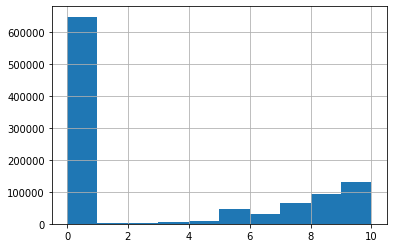

In [ ]:
df['Book-Rating'].hist(bins=10)

In [32]:
grouped_df = df.groupby(['User-ID', 'ISBN', 'Book-Title']).mean().reset_index() # not a big sense as there is one rating for one book by user
# implicit data. To make explicit we may add to rating author-score (mean author rating) and bookscore (mean book rating), we will do this in tf section
grouped_df.drop_duplicates(inplace=True)
grouped_df['Book-Title'] = grouped_df['Book-Title'].astype("category")
grouped_df['User-ID'] = grouped_df['User-ID'].astype("category")
grouped_df['ISBN'] = grouped_df['ISBN'].astype("category")
grouped_df['person_id'] = grouped_df['User-ID'].cat.codes # Return Series of codes as well as the index.
grouped_df['content_id'] = grouped_df['ISBN'].cat.codes

In [33]:
sparse_content_person = sparse.csr_matrix((grouped_df['Book-Rating'].astype(float), (grouped_df['content_id'], grouped_df['person_id'])))
sparse_person_content = sparse.csr_matrix((grouped_df['Book-Rating'].astype(float), (grouped_df['person_id'], grouped_df['content_id'])))

In [34]:
model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.1, iterations=50, use_gpu=False,
                                             random_state=1)
alpha = 40
data = (sparse_content_person * alpha).astype('double')
model.fit(data)

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
# better use it for explicit data, not just for rating
def recommend_similar(personid, top, rate=6, n_similar=10):
    books_read_by_user = grouped_df.loc[grouped_df['User-ID'] == personid, 'ISBN'].to_list()
    condition = ((grouped_df['User-ID'] == personid) & (grouped_df['Book-Rating'] >= rate))
    books_highly_rated_by_user = grouped_df.loc[condition, 'ISBN'].to_list()

    if len(books_highly_rated_by_user) == 0:
        rate -= 1
        if rate < 0:
            print('No books found')
            return None
        return recommend_similar(personid, top, rate=rate)
    
    person_vecs = model.user_factors
    content_vecs = model.item_factors
    content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1))

    data = pd.DataFrame(columns=['Title', 'Rating'])

    for isbn in books_highly_rated_by_user:
        content_id = grouped_df.loc[grouped_df['ISBN'] == isbn, 'content_id'].unique()[0]
        scores = content_vecs.dot(content_vecs[content_id]) / content_norms
        
        top_idx = np.argpartition(scores, -n_similar)[-n_similar:]
        similar = sorted(zip(top_idx, scores[top_idx] / content_norms[content_id]), key=lambda x: -x[1])

        for content in similar:
            idx, score = content
            loc_data = {}
            title = grouped_df['Book-Title'].loc[grouped_df.content_id == idx].iloc[0]
            rating = grouped_df['Book-Rating'].loc[grouped_df.content_id == idx].mean()
            if grouped_df['ISBN'].loc[grouped_df.content_id == idx].iloc[0] in books_read_by_user:
                continue
            loc_data['Title'] = title
            loc_data['Rating'] = rating
            data = data.append(loc_data, ignore_index=True)

    return data.sort_values(by='Rating', ascending=False).head(top)

In [24]:
recommend_similar(13479, 10)

,Title,Rating
5,For Whom Bell Tolls,9.000000
7,"Tallulah, Darling: A Biography of Tallulah Ban...",5.666667
8,Nice Work (King Penguin),3.000000
6,Ghostkiller,2.333333
3,The Country of the Pointed Firs : And Other St...,1.777778
2,A Poet's Guide to Poetry (Chicago Guides to Wr...,0.333333
0,Playboy In Pursuit (Australian Playboys) (Harl...,0.000000
1,Silverhair (Mammoth Trilogy),0.000000
4,The Quest for Life in Amber (Helix Book),0.000000


In [ ]:
grouped_df.groupby('User-ID').count().sort_values(by='ISBN', ascending=False).iloc[30000:, :]

,ISBN,Book-Title,Book-Rating,person_id,content_id
User-ID,,,,,
51275,3,3,3,3,3
79146,3,3,3,3,3
13479,3,3,3,3,3
30359,3,3,3,3,3
236186,3,3,3,3,3
...,...,...,...,...,...
119065,1,1,1,1,1
119082,1,1,1,1,1
119085,1,1,1,1,1


In [ ]:
grouped_df[grouped_df['User-ID'] == 13479]

,User-ID,ISBN,Book-Title,Book-Rating,person_id,content_id
48282,13479,0061059056,Hogfather,6,4174,9517
48283,13479,0304353493,Tales From/Kings African Rifles,0,4174,27941
48284,13479,0971880107,Wild Animus,4,4174,215952


In [ ]:
grouped_df[grouped_df['ISBN'] == '0155061224']

,User-ID,ISBN,Book-Title,Book-Rating,person_id,content_id
580157,159181,0155061224,Rites of Passage,0,52485,22731
1022705,276726,0155061224,Rites of Passage,5,91363,22731


In [ ]:
# ALS collaborative

In [43]:
def recommend(person_id, num_contents=10):
    person_interactions = sparse_person_content[person_id,:].toarray()
    person_interactions = person_interactions.reshape(-1) + 1
    person_interactions[person_interactions > 1] = 0

    person_vecs = sparse.csr_matrix(model.user_factors)
    content_vecs = sparse.csr_matrix(model.item_factors)

    rec_vector = person_vecs[person_id,:].dot(content_vecs.T).toarray()
    
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]

    print(person_interactions.shape, rec_vector_scaled.shape)
    recommend_vector = person_interactions * rec_vector_scaled

    content_idx = np.argsort(recommend_vector)[::-1][:num_contents]
    
    titles = []
    ratings = []

    for idx in content_idx:
        titles.append(grouped_df['Book-Title'].loc[grouped_df.content_id == idx].iloc[0])
        #ratings.append(recommend_vector[idx])
        ratings.append(grouped_df['Book-Rating'].loc[grouped_df.content_id == idx].mean())

    recommendations = pd.DataFrame({'Title': titles, 'Rating': ratings})

    return recommendations

In [44]:
recommend(13479, 10)

(270148,) (92106,)


ValueError: ignored

In [ ]:
# hybrid filtering
content_data = recommend_similar(13479, 10)
collab_data = recommend(13479, 10)
pd.concat([content_data, collab_data], axis=0).sort_values('Rating', ascending=False).head(10)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
tf.random.set_seed(1)
model_dir = r'/content/drive/My Drive/data/books/'

In [ ]:
df = ratings.merge(users, on=['User-ID'], how='left').dropna()
df = df.merge(books, on=['ISBN'], how='left').drop_duplicates().drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'Publisher', 'Year-Of-Publication'], axis=1)

In [ ]:
df.dropna(inplace=True)
df['Book-Rating'] = df['Book-Rating'].astype(np.float32)

In [ ]:
# add mean rating by author
# add mean rating by book
# add mean rating by age

In [ ]:
df['Location'] = df['Location'].apply(lambda x: x.split()[-1])
df['Book-Author'] = df['Book-Author'].apply(lambda x: x.lower().replace(' ', '').replace('.', ''))

In [ ]:
df.sample()

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author
374468,125774,0441676308,9.0,iran,36.0,Power of Three,dianawynnejones


In [ ]:
data_il = df.groupby(['ISBN', 'Location']).agg({'Book-Rating': 'mean'}).reset_index() # mean by isbn-location
data_il.rename(columns={'Book-Rating': 'Mean_ISBN_Loc'}, inplace=True)

data_ia = df.groupby(['ISBN', 'Age']).agg({'Book-Rating': 'mean'}).reset_index() # mean by isbn-age
data_ia.rename(columns={'Book-Rating': 'Mean_ISBN_age'}, inplace=True)

popular_dict = df.groupby(['Book-Author'])['Book-Rating'].count().to_dict()  # popular authors

In [ ]:
df = df.merge(data_il, on=['ISBN', 'Location'], how='left')
df = df.merge(data_ia, on=['ISBN', 'Age'], how='left')
df['Popular_Author'] = df['Book-Author'].map(popular_dict)

In [ ]:
df.sample()

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Mean_ISBN_Loc,Mean_ISBN_age,Popular_Author
534129,198699,0671887947,0.0,usa,49.0,The Whole Truth,nancypickard,1.0,0.0,139


In [ ]:
user_ids = df["User-ID"].unique().tolist()

user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

books_ids = df["ISBN"].unique().tolist()

book2book_encoded = {x: i for i, x in enumerate(books_ids)}
book_encoded2book = {i: x for i, x in enumerate(books_ids)}

df["user"] = df["User-ID"].map(user2user_encoded)
df["book"] = df["ISBN"].map(book2book_encoded)

df.sample(2)

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Mean_ISBN_Loc,Mean_ISBN_age,Popular_Author,user,book
232655,88937,0451191706,0.0,usa,39.0,Critical Conditions,stephenwhite,1.52381,0.0,306,17655,28352
299282,111019,0060927542,6.0,usa,21.0,Mr. Ives' Christmas,oscarhijuelos,1.62500,6.0,79,21908,36162


In [ ]:
# frequency encoding
total = len(df.Location)
loc_dict = df.Location.value_counts().to_dict()
df.Location = df.Location.map(lambda x: loc_dict.get(x) / total)
#loc_a_dict = df['Book-Author'].value_counts().to_dict()
#df['Book-Author'] = df['Book-Author'].map(lambda x: loc_a_dict.get(x) / total)
df.sample(2)

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Mean_ISBN_Loc,Mean_ISBN_age,Popular_Author,user,book
686063,251003,0517118238,8.0,0.735151,37.0,Margaret Truman: Three Complete Mysteries : Mu...,margarettruman,4.0,8.0,456,48894,129045
31144,13552,0446329436,0.0,0.735151,32.0,Chances,jackiecollins,0.0,0.0,413,2955,22824


In [ ]:
# may be better for book title, we can easily encode authors with classic methods
vocab_size = 10000
sequence_length = 30
to_adapt = list(set(itertools.chain.from_iterable(df['Book-Title'].apply(lambda x: x.split()).to_list())))
text_dataset = tf.data.Dataset.from_tensor_slices(to_adapt)
vectorize_layer = layers.TextVectorization(
                          max_tokens=vocab_size,
                          output_mode='int',
                          output_sequence_length=sequence_length)
vectorize_layer.adapt(text_dataset.batch(64))

In [ ]:
embedding_dim=16
# seems like this is complex type of encoding, where we get single float value from small-size text
model_author = keras.Sequential([
  keras.Input(shape=(1,), dtype=tf.string),
  vectorize_layer,
  keras.layers.Embedding(vocab_size, embedding_dim, name="embedding"),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(1)
])
#df['Book-Title'] = model_author.predict(df['Book-Title'].values)
df['Book-Title_Vec'] = model_author.predict(df['Book-Title'].values)
df.sample(2)

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Mean_ISBN_Loc,Mean_ISBN_age,Popular_Author,user,book,Book-Title_Vec
154822,59172,0446613436,10.0,0.086858,36.0,The Guardian,nicholassparks,6.666667,10.0,1900,11870,2798,-0.011749
711721,260183,067157745X,0.0,0.086858,25.0,Douglas Adams Starship Titanic,douglasadams,0.000000,0.0,1190,50755,193559,-0.010056


In [ ]:
# use book-title column in DL model and book-title-vec in clustering?

In [ ]:
df['Book-Author'].nunique()

83296

In [ ]:
df = df.sample(frac=1, random_state=42)
X = df[["user", "book", "Location", "Age", "Book-Title", "Mean_ISBN_Loc", "Mean_ISBN_age", "Popular_Author"]].values
y = df["Book-Rating"].values

scaler = MinMaxScaler()
scaler_X = MinMaxScaler()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42)
y_train = scaler.fit_transform(y_train.reshape(-1,1))
y_valid = scaler.transform(y_valid.reshape(-1,1))

X_train[:, -3:] = scaler_X.fit_transform(X_train[:, -3:])
X_valid[:, -3:] = scaler_X.transform(X_valid[:, -3:])

In [ ]:
num_users = len(user2user_encoded)
num_books = len(book_encoded2book)
num_locations = df.Location.nunique()
num_age = df.Age.nunique()
num_isbn_loc = df.Mean_ISBN_Loc.nunique()
num_isbn_age = df.Mean_ISBN_age.nunique()
num_titles = df['Book-Title'].nunique()

In [ ]:
# add model with callbacks=early_stopping, model_checkpoint, reduce_lr
# Embedding+dot for user-book + tf.concat with 3 exogenious variables: Mean_ISBN_age, Mean_ISBN_loc, Popular_Author
# with Linear (+ regularizer) + Dropout
# RMSE, MAE, MSE for model validation metrics
X_train.shape[-1]

8

In [ ]:
EMBEDDING_SIZE = 200  # was 50
batch_size = 256
checkpoint_path = "cp.ckpt"
AUTOTUNE = tf.data.AUTOTUNE

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_books, num_isbn_age, num_isbn_loc, num_titles,
                 embedding_size, exog=False, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size
        self.exog = exog
        input_shape = X_train.shape[-1]-5 if self.exog else X_train.shape[-1]-4  # tune
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.book_embedding = layers.Embedding( 
            num_books,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.book_bias = layers.Embedding(num_books, 1)

        self.dense = tf.keras.Sequential([
                                          tf.keras.layers.Dense(64, activation='relu',
                                                                input_shape=(input_shape,),
                                                                kernel_regularizer=keras.regularizers.l2(1e-4)),
                                          tf.keras.layers.Dropout(0.5),
                                          tf.keras.layers.Dense(1)
        ])
        self.age = layers.Embedding(num_isbn_age, embedding_size, 
                                    embeddings_initializer="he_normal",
                                    embeddings_regularizer=keras.regularizers.l2(1e-6),)
        self.age_bias = layers.Embedding(num_isbn_age, 1)
        self.location = layers.Embedding(num_isbn_loc, embedding_size,
                                         embeddings_initializer="he_normal",
                                         embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.location_bias = layers.Embedding(num_isbn_loc, 1)
        self.titles = layers.Embedding(num_titles, embedding_size,
                                        embeddings_initializer="he_normal",
                                        embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.titles_bias = layers.Embedding(num_titles, 1)

    def call(self, inputs):  # side features help with users, that are inactive: like age, location or other 
                             # only users parameters, not books parameters. 
                             # For book parameters we already use encoded ISBN

        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        book_vector = self.book_embedding(inputs[:, 1])
        book_bias = self.book_bias(inputs[:, 1])
        dot_user_book = tf.tensordot(user_vector, book_vector, 2)
        if self.exog is not None:
            age_vector = self.age(inputs[:, 6])
            age_bias = self.age_bias(inputs[:, 6])
            dot_user_age = tf.tensordot(user_vector, age_vector, 2)
        
            loc_vector = self.location(inputs[:, 5])
            loc_bias = self.location_bias(inputs[:, 5])
            dot_user_loc = tf.tensordot(user_vector, loc_vector, 2)
        
            titles_vector = self.titles(inputs[:, 4])  # not! very useful for new users as this is characteristic of a book
            titles_bias = self.titles_bias(inputs[:, 4])
            dot_user_titles = tf.tensordot(user_vector, titles_vector, 2)
        
            vectors = dot_user_book + dot_user_age + dot_user_loc + dot_user_titles
            biases = user_bias + book_bias + age_bias + loc_bias + titles_bias  
            x = vectors + biases
        else: 
            x = dot_user_book + user_bias + book_bias

        # The sigmoid activation forces the rating to be between 0 and 1
        if self.exog:
            # var 2: learn dense on x2 and then add x+x2, pass to sigmoid
            x2 = self.dense(inputs[:, -3:])
            x = tf.nn.sigmoid(x)
            x2 = tf.nn.sigmoid(x2)
            return (x+x2)/2.
        elif not self.exog:
            # var 1 concatenate exogs with dot result and pass to dense
            x = tf.concat([inputs[:, -3:], x], axis=1)
            x = self.dense(x)
            return tf.nn.sigmoid(x)
        else:
            return tf.nn.sigmoid(x)

model = RecommenderNet(num_users, num_books, num_isbn_age, num_isbn_loc, num_titles, EMBEDDING_SIZE, exog=True)

def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  return r2

metrics = [
           tf.keras.metrics.MeanAbsoluteError(name='MAE'),
           tf.keras.metrics.MeanSquaredError(name='MSE'),
           tf.keras.metrics.RootMeanSquaredError(name='RMSE'),
           R_squared,
]
# BinaryCrossEntropy is ok as if we use sigmoid in output - probability distribution
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.03), metrics=metrics,
)
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=False),
             tf.keras.callbacks.ReduceLROnPlateau(patience=4),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
             tf.keras.callbacks.TensorBoard(log_dir="logs"),
            ]
""" 
var 1 add padded tensors of x2 and dot result, pass to dense
x2 = tf.cast(inputs[:, 2:], dtype=np.float32)
paddings1 = tf.constant([[0,0], [3,0]])
paddings2 = tf.constant([[0,0],[0,1]])
x = tf.pad(x, paddings1) + tf.pad(x2, paddings2)
a = tf.print(x)
x1 = tf.expand_dims(x, axis=0) # add new dimension
x = tf.concat((inputs[:, 2:], inputs[:, 2:]*0 + x), axis=0)  # trick to set dimendion of resulting vector as highest
"""

' \nvar 1 add padded tensors of x2 and dot result, pass to dense\nx2 = tf.cast(inputs[:, 2:], dtype=np.float32)\npaddings1 = tf.constant([[0,0], [3,0]])\npaddings2 = tf.constant([[0,0],[0,1]])\nx = tf.pad(x, paddings1) + tf.pad(x2, paddings2)\na = tf.print(x)\nx1 = tf.expand_dims(x, axis=0) # add new dimension\nx = tf.concat((inputs[:, 2:], inputs[:, 2:]*0 + x), axis=0)  # trick to set dimendion of resulting vector as highest\n'

In [ ]:
arr2 = tf.cast(X_train[:2, -3:], dtype=np.float32)
arr1 = tf.constant([[10.], [9.]])
tf.concat([arr1, arr2], axis=1)
X_train[:2, :]

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).cache()
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE) 

In [ ]:
history = model.fit(train_ds, epochs=8, verbose=1, callbacks=callbacks, validation_data=val_ds) # epochs=20-30

Epoch 1/8
2649/2649 [==============================] - 226s 84ms/step - loss: 0.3093 - MAE: 0.1448 - MSE: 0.0566 - RMSE: 0.2378 - R_squared: 0.6202 - val_loss: 0.3033 - val_MAE: 0.1403 - val_MSE: 0.0552 - val_RMSE: 0.2351 - val_R_squared: 0.6286 - lr: 0.0300
Epoch 2/8
2649/2649 [==============================] - 223s 84ms/step - loss: 0.3371 - MAE: 0.1445 - MSE: 0.0565 - RMSE: 0.2377 - R_squared: 0.6207 - val_loss: 0.3207 - val_MAE: 0.1421 - val_MSE: 0.0555 - val_RMSE: 0.2355 - val_R_squared: 0.6270 - lr: 0.0300
Epoch 3/8
2649/2649 [==============================] - 222s 84ms/step - loss: 0.3183 - MAE: 0.1453 - MSE: 0.0570 - RMSE: 0.2387 - R_squared: 0.6175 - val_loss: 0.3052 - val_MAE: 0.1410 - val_MSE: 0.0556 - val_RMSE: 0.2359 - val_R_squared: 0.6257 - lr: 0.0300
Epoch 4/8
2649/2649 [==============================] - 223s 84ms/step - loss: 0.3134 - MAE: 0.1462 - MSE: 0.0579 - RMSE: 0.2406 - R_squared: 0.6111 - val_loss: 0.3058 - val_MAE: 0.1442 - val_MSE: 0.0571 - val_RMSE: 0.2390 -

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
model.save(model_dir)

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/books/assets


In [ ]:
model.summary()

Model: "recommender_net_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_52 (Embedding)    multiple                  2694350   
                                                                 
 embedding_53 (Embedding)    multiple                  53887     
                                                                 
 embedding_54 (Embedding)    multiple                  11450000  
                                                                 
 embedding_55 (Embedding)    multiple                  229000    
                                                                 
 sequential_13 (Sequential)  (None, 1)                 385       
                                                                 
Total params: 14,427,622
Trainable params: 14,427,622
Non-trainable params: 0
_________________________________________________________________


In [ ]:
new_model = tf.keras.models.load_model(model_dir)

In [ ]:
# without exogenious variables
user_id = 13479
books_read_by_user = df[df['User-ID'] == user_id]
books_not_read = df[~df["ISBN"].isin(books_read_by_user['ISBN'].values)]["ISBN"] ##
books_not_read = list(set(books_not_read).intersection(set(book2book_encoded.keys()))) ##

books_not_read = [[book2book_encoded.get(x)] for x in books_not_read] ##
user_encoder = user2user_encoded.get(user_id)

user_book_array = np.hstack(([[user_encoder]] * len(books_not_read), books_not_read)) ##

In [ ]:
# with exogenious variables
user_id = 13479
books_read_by_user = df[df['User-ID'] == user_id]
books_not_read = df[~df["ISBN"].isin(books_read_by_user['ISBN'].values)][["ISBN", "Location", "Age", "Book-Title", "Mean_ISBN_Loc", "Mean_ISBN_age", "Popular_Author"]]
books_exog_vars = books_not_read.groupby('ISBN').mean().reset_index()[["Location", "Age", "Book-Title", "Mean_ISBN_Loc", "Mean_ISBN_age", "Popular_Author"]]
books_not_read_ = list(set(books_not_read["ISBN"]).intersection(set(book2book_encoded.keys())))

books_not_read_ = [[book2book_encoded.get(x)] for x in books_not_read_] 
user_encoder = user2user_encoded.get(user_id)

user_book_array = np.hstack(([[user_encoder]] * len(books_not_read_), books_not_read_, books_exog_vars))

In [ ]:
user_book_array[:3]

array([[2.94400000e+03, 7.03790000e+04, 8.68578256e-02, 4.70000000e+01,
        7.60276197e-03, 8.00000000e+00, 8.00000000e+00, 1.00000000e+00],
       [2.94400000e+03, 6.81660000e+04, 3.56418426e-02, 5.70000000e+01,
        9.45000071e-03, 0.00000000e+00, 0.00000000e+00, 1.10000000e+01],
       [2.94400000e+03, 1.46121000e+05, 3.56418426e-02, 2.90000000e+01,
        9.42021422e-03, 0.00000000e+00, 0.00000000e+00, 3.00000000e+00]])

In [ ]:
model.dense.input_shape

(None, 4)

In [ ]:
ratings = model.predict(user_book_array).flatten()

In [ ]:
ratings

array([0.56155264, 0.00467403, 0.00468318, ..., 0.00463469, 0.00459737,
       0.00459003], dtype=float32)

In [ ]:
top_ratings_indices = ratings.argsort()[-20:][::-1]
recommended_books_ids = [book_encoded2book.get(books_not_read_[x][0]) for x in top_ratings_indices]

In [ ]:
rec_df = df[df.ISBN.isin(recommended_books_ids)][['Book-Title', 'Book-Rating']].groupby('Book-Title').mean().sort_values('Book-Rating', ascending=False).head(10)
selected_isbn = df.loc[df['Book-Title'].isin(rec_df.index.to_list()), 'ISBN'].unique().tolist()
df.loc[df.ISBN.isin(selected_isbn), ['ISBN', 'Book-Rating']].groupby('ISBN').mean().sort_values('Book-Rating', ascending=False).head(10)

,Book-Rating
ISBN,
284055335X,10.0
0920656080,10.0
0553581031,9.0
0345444841,8.5
0764506927,8.0
0061051799,8.0
0887393187,7.0
1575667231,6.0
0670032050,4.5


In [ ]:
# clusters
# select user_id and look up for users from the same cluster
# take best reted movies from that cluster, except that user_id had already watched
# set_index: book
"""
emb_count_0 = df.loc[df[self.target] == 0, 'Region_Code'].count()
emb_count_1 = df.loc[df[self.target] == 1, 'Region_Code'].count()

for item in df.Region_Code.unique():
    percent_non_event = df.loc[((df[self.target] == 0) & (df.Region_Code == item)), 'Region_Code'].count() / emb_count_0
    percent_event = df.loc[((df[self.target] == 1) & (df.Region_Code == item)), 'Region_Code'].count() / emb_count_1
    self.region_woe_vocab[item] = np.log(percent_non_event / percent_event)

map
"""

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# frequency encoding
loc_a_dict = df['Book-Author'].value_counts().to_dict()
df['Book-Author'] = df['Book-Author'].apply(lambda x: loc_a_dict.get(x) / total) * 1000 # map?

In [ ]:
# weight of evidence encoding: takes enormous time to calculate due to having huge amount of unique categories
"""
vocab = {}
emb_count_0 = df.loc[df['Book-Rating'] < 6, 'Book-Author'].count()
emb_count_1 = df.loc[df['Book-Rating'] >= 6, 'Book-Author'].count()
for item in df['Book-Author'].unique():
    percent_non_event = df.loc[((df['Book-Rating'] < 6) & (df['Book-Author'] == item)), 'Book-Author'].count() / emb_count_0
    percent_event = df.loc[((df['Book-Rating'] >= 6) & (df['Book-Author'] == item)), 'Book-Author'].count() / emb_count_1
    vocab[item] = np.log(percent_non_event / percent_event + 1e-6)
df['Book-Author'] = df['Book-Author'].map(vocab)
"""

In [ ]:
df.sample(5)

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Mean_ISBN_Loc,Mean_ISBN_age,Popular_Author,user,book,Book-Title_Vec
450576,168245,0806913037,0.0,0.086858,37.0,Inspirational Christmas Crafts,0.001327,0.000000,0.0,1,32917,167630,-0.010393
716802,262399,0821772287,0.0,0.735151,48.0,The Awakening,0.347803,1.714286,0.0,262,51163,46422,-0.011954
491907,182053,088404632X,0.0,0.086858,30.0,Dianetics: The Modern Science of Mental Health,0.346476,0.000000,0.0,261,35614,34255,-0.010518
32666,14232,8874973632,0.0,0.013206,23.0,Lo schermo insanguinato: Il cinema italiano de...,0.001327,0.000000,0.0,1,3090,23767,-0.001984
80218,31826,0553575791,5.0,0.735151,54.0,Simeon's Bride,0.010620,1.250000,5.0,8,6559,49610,-0.011472


In [ ]:
# train_data = df.values[:, np.arange(2,10)] # when there is no book-title-vec
train_data = df.values[:, [2,3,4,6,7,8,9,12]]
train_data = MinMaxScaler().fit_transform(train_data)

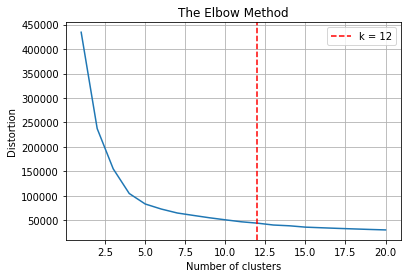

In [ ]:
# to workout
distortions, silhuettes = [], []
max_k = 20

for i in range(1, max_k + 1):
    if train_data.shape[0] >= i:
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=1, tol=1e-04)
        kmeans.fit(train_data)
        distortions.append(kmeans.inertia_)
        if i == 1:
            continue
        # silhuettes.append(silhouette_score(train_data, kmeans.predict(train_data), random_state=1))
k = [i*100 for i in np.diff(distortions, 2)].index(min([i*100 for i in np.diff(distortions,2)]))

fig, ax = plt.subplots()
ax.plot(range(1, 21), distortions)
ax.axvline(k, ls='--', color="red", label="k = " + str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")
plt.grid()
plt.legend(loc='best')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=12, init='k-means++', n_init=10, max_iter=300, random_state=1, tol=1e-04)
df['Cluster'] = kmeans.fit_predict(train_data)

In [ ]:
user_id = 13479
df.loc[df['User-ID'] == user_id, :].groupby('Book-Rating').mean().sort_values('Book-Rating', ascending=False)['Cluster'].head(1)
# so let's observe 8 cluster

Book-Rating
6.0    8
Name: Cluster, dtype: int32

In [ ]:
clust_df = df[df.Cluster == 8]

In [ ]:
clust_df.loc[clust_df['User-ID'] != user_id, :]

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Mean_ISBN_Loc,Mean_ISBN_age,Popular_Author,user,book,Book-Title_Vec,Cluster
2,276729,0521795028,6.0,0.000019,16.0,The Amsterdam Connection : Level 4 (Cambridge ...,0.002655,6.000000,6.000000,2,1,2,-0.008422,8
12,276748,0747558167,6.0,0.000020,39.0,Apricots on the Nile: A Memoir with Recipes,0.006637,6.000000,6.000000,5,4,12,-0.008424,8
14,276755,0451166892,5.0,0.026069,32.0,The Pillars of the Earth,1.668658,2.500000,1.333333,1257,6,14,-0.011402,8
17,276762,0380711524,5.0,0.026069,25.0,See Jane Run,0.658436,5.000000,5.000000,496,7,17,-0.009798,8
43,276786,8478442588,6.0,0.017357,34.0,El Elogio de La Sombra,0.003982,3.000000,6.000000,3,10,43,-0.009524,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753062,276670,0804115761,8.0,0.086858,30.0,Thousand Acres,0.736758,3.000000,3.714286,555,53879,2277,-0.010983,8
753068,276670,1551520648,4.0,0.086858,30.0,Jane: A novel,0.002655,2.000000,4.000000,2,53879,98480,-0.012803,8
753073,276670,1569472041,8.0,0.086858,30.0,Adrian Mole: The Cappuccino Years,0.286738,4.000000,8.000000,216,53879,100097,-0.007101,8
753075,276670,1573220485,5.0,0.086858,30.0,The Beach,0.172574,4.200000,6.000000,130,53879,25995,-0.009749,8


In [ ]:
"""
1) just get most rated books from clust_df, that user had not read
2) get similar books for user using cosine_similarity for vectorized book-title or als with rating
"""

In [ ]:
# reassign user ids, because of issues in indexes in sparse_person_content matrix
user_ids = clust_df["User-ID"].unique().tolist()

user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

books_ids = df["ISBN"].unique().tolist()

book2book_encoded = {x: i for i, x in enumerate(books_ids)}
book_encoded2book = {i: x for i, x in enumerate(books_ids)}

clust_df["user"] = clust_df["User-ID"].map(user2user_encoded)
clust_df["book"] = clust_df["ISBN"].map(book2book_encoded)

In [ ]:
grouped_df = clust_df.groupby(['User-ID', 'ISBN', 'Book-Title']).mean().reset_index() 
grouped_df.drop_duplicates(inplace=True)
grouped_df['Book-Title'] = grouped_df['Book-Title'].astype("category")
grouped_df['User-ID'] = grouped_df['User-ID'].astype("category")
grouped_df['ISBN'] = grouped_df['ISBN'].astype("category")
grouped_df['person_id'] = grouped_df['User-ID'].cat.codes # Return Series of codes as well as the index.
grouped_df['content_id'] = grouped_df['ISBN'].cat.codes

In [ ]:
sparse_content_person = sparse.csr_matrix((grouped_df['Book-Rating'].astype(float), (grouped_df['content_id'], grouped_df['person_id'])))
sparse_person_content = sparse.csr_matrix((grouped_df['Book-Rating'].astype(float), (grouped_df['person_id'], grouped_df['content_id'])))

In [ ]:
model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.1, iterations=50, use_gpu=False,
                                             random_state=1)
alpha = 40
data = (sparse_content_person * alpha).astype('double')
model.fit(data)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
recommend_similar(user_id, 10)  # function form the beginning of notebook

,Title,Rating
1,Precipice: A Novel,9.0
2,Lines in the sand,7.0
0,That Old Devil Moon (Women Who Dare) (Harlequi...,5.0
3,JA zum Stress. HÃ?Â¶chstleistungen bringen und...,5.0
4,Im Atemhaus wohnen: Gedichte,5.0
5,Das Magazin.,5.0
6,Therapie.,5.0
7,Absahnen und abhauen. Deutschland vor dem Chaos.,5.0
8,Wie ein Vogel im Aquarium. Aus dem Leben eines...,5.0


In [ ]:
enc_user_id = user2user_encoded.get(user_id) 
content_data = recommend_similar(13479, 10)
collab_data = recommend(enc_user_id, 10)  # ????
pd.concat([content_data, collab_data], axis=0).sort_values('Rating', ascending=False).head(10)
# get isbn by title value from clust_df and get book-title as string from books

,Title,Rating
1,Precipice: A Novel,9.000000
7,Einmal ist keinmal.,8.250000
2,Hin und weg.,8.000000
4,Der Hahn ist tot. Roman.,7.777778
3,Die Welle.,7.400000
5,Wild Animus,7.022727
2,Lines in the sand,7.000000
6,ZwÃ?Â¶lf.,7.000000
0,Russendisko.,6.680000
1,Regenroman.,6.625000


In [ ]:
df['Book-Title'].nunique(), df['Book-Title_Vec'].nunique()

(205173, 178198)

In [ ]:
grouped_df[grouped_df['User-ID'] == user_id]

,User-ID,ISBN,Book-Title,Book-Rating,Location,Age,Book-Author,Mean_ISBN_Loc,Mean_ISBN_age,Popular_Author,user,book,Book-Title_Vec,Cluster,person_id,content_id
1353,13479,0061059056,Hogfather,6.0,0.005194,31.0,1.636798,3.0,6.0,1233,567,22606,-0.011395,8,484,721


In [ ]:
grouped_df[grouped_df.user == enc_user_id]

,User-ID,ISBN,Book-Title,Book-Rating,Location,Age,Book-Author,Mean_ISBN_Loc,Mean_ISBN_age,Popular_Author,user,book,Book-Title_Vec,Cluster,person_id,content_id
1353,13479,0061059056,Hogfather,6.0,0.005194,31.0,1.636798,3.0,6.0,1233,567,22606,-0.011395,8,484,721
